Utility Functions
- NOTE: tensors are organized as follows: [BATCH_SIZE, CHANNELS, WIDTH, HEIGHT]

In [1]:
import torch
import torch.nn.functional as func
import PIL.Image
import random
import json
import pathlib
import numpy as np
import matplotlib.gridspec as gridspec
import torchvision.transforms.functional as trans

from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

# * loads an image and converts to a tensor
# *     default tensor shape: [BATCH_SIZE (1), CHANNELS (4), WIDTH (_size), HEIGHT (_size)]
def load_image_as_tensor(_path, _size, _resample=PIL.Image.Resampling.BICUBIC):
    img = PIL.Image.open(_path)
    img = img.resize((_size, _size), _resample)
    img = np.float32(img) / 255.0
    img[..., :3] *= img[..., 3:]
    return torch.from_numpy(img).permute(2, 0, 1)[None, ...]

# * given a tensor of default shape, visualize the first 4 channels as a RGBA image
def show_tensor_as_image(_tensor):
    img = to_rgb(_tensor).squeeze().permute(1, 2, 0)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

# * takes the first 4 channels of a tensor of default shape and converts to a RGB image
def to_rgb(_x, _alpha='BLACK'):
    rgb, a = _x[:, :3], _x[:, 3:4]
    if _alpha == 'BLACK':
        return torch.clamp(rgb, 0.0, 1.0)
    elif _alpha == 'WHITE':
        return torch.clamp(1.-a + rgb, 0.0, 1.0)

# * creates a circle mask centered at a position of a given radius
def circle_mask(_size, _radius, _pos):
    Y, X = np.ogrid[:_size, :_size]
    dist_from_center = np.sqrt((X - _pos[0])**2 + (Y-_pos[1])**2)
    mask = dist_from_center >= _radius
    return mask

# * creates a mask for half the screen
def half_mask(_size, _type):
    mask_types = ['left', 'right', 'top', 'bottom']
    if _type == 'rand':
        _type = mask_types[np.random.randint(0, 4)]
    mat = np.zeros([_size, _size])
    if _type == 'left':
        mat[:, _size//2:] = 1.0
    elif _type == 'right':
        mat[:, :-_size//2] = 1.0
    elif _type == 'top':
        mat[_size//2:, :] = 1.0
    elif _type == 'bottom':
        mat[:-_size//2, :] = 1.0
    return mat

# * shows a batch before and after a forward pass given two (2) tensors
def show_batch(_batch_size, _before, _after, _dpi=256):
    fig = plt.figure(figsize=(_batch_size, 2), dpi=_dpi)
    axarr = fig.subplots(nrows=2, ncols=_batch_size)
    gspec = gridspec.GridSpec(2, _batch_size)
    gspec.update(wspace=0.1, hspace=0) # set the spacing between axes.
    plt.clf()
    for i in range(_batch_size):
        img_i = _before[i].unsqueeze(0)
        img_rgb = to_rgb(img_i, _alpha='WHITE').squeeze().permute(1, 2, 0)
        axarr[0, i] = plt.subplot(gspec[i])
        axarr[0, i].set_xticks([])
        axarr[0, i].set_yticks([])
        axarr[0, i].imshow(img_rgb, aspect='equal')
        axarr[0, i].set_title(str(i), fontsize=8)   
    for i in range(_batch_size):
        img_i = _after[i].unsqueeze(0)
        img_rgb = to_rgb(img_i, _alpha='WHITE').squeeze().permute(1, 2, 0)
        axarr[1, i] = plt.subplot(gspec[i+_batch_size])
        axarr[1, i].set_xticks([])
        axarr[1, i].set_yticks([])
        axarr[1, i].imshow(img_rgb, aspect='equal') 
    plt.show()

# * find GPU available
clear_output()
!nvidia-smi -L

# * sets the device
# *     defaults to 'cuda'
_DEVICE_ = 'cuda' if torch.cuda.is_available() else 'cpu'
print ('cuda available? ', torch.cuda.is_available())
print ('device: ', _DEVICE_)

GPU 0: NVIDIA GeForce GTX 1660 Ti (UUID: GPU-d77bcb98-b41a-4494-1c93-f4f7d0b55d9c)
cuda available?  True
device:  cuda


In [2]:
# experiment block

# img = load_image_as_tensor('..\\_images\\'+'cowboy.png', 40)
# img = func.pad(img, (12, 12, 12, 12), 'constant', 0)

# mask = half_mask(64, 'rand')
# img = img * torch.tensor(mask, dtype=torch.int64)
# print ('random half mask:')
# show_tensor_as_image(img)

Load Pre-Made Seed

seed_img.shape:  torch.Size([1, 4, 64, 64])


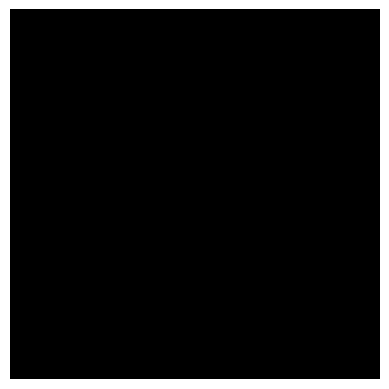

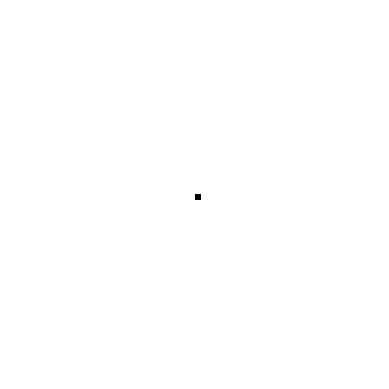

In [3]:
_SEED_FILE_ = '_1_seed_64.png'
_SIZE_ = 64
_SEED_ANGLE_RAD_ = (0)*np.pi

seed_img = load_image_as_tensor('..\\_seeds\\'+_SEED_FILE_,  _SIZE_)
seed_img = trans.rotate(seed_img, np.rad2deg(_SEED_ANGLE_RAD_))
print ('seed_img.shape: ', seed_img.shape)
show_tensor_as_image(to_rgb(seed_img))
show_tensor_as_image(to_rgb(seed_img, 'WHITE'))

Target Image to Train Model
- NOTE: seed _SIZE_ should equal _TARGET-SIZE_ + (2 * _PAD_)

target_img.shape: 

 torch.Size([1, 4, 64, 64])


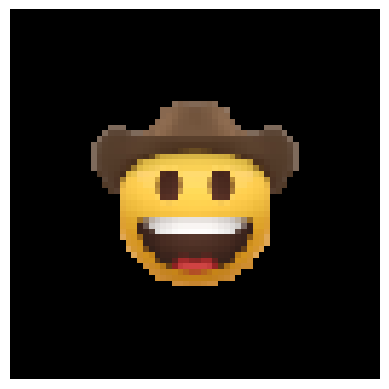

In [4]:
_TARGET_FILE_ = 'cowboy.png'
_TARGET_SIZE_ = 40
_PAD_ = 12

target_img = load_image_as_tensor('..\\_images\\'+_TARGET_FILE_, _TARGET_SIZE_)
target_img = func.pad(target_img, (_PAD_, _PAD_, _PAD_, _PAD_), 'constant', 0)
print ('target_img.shape: ', target_img.shape)
show_tensor_as_image(target_img)

Perceptions:
- LAPLACIAN: isotropic nca model
- SOBEL_MAG: isotrpic nca variant which adds upon the 'laplacian' model by making use of the magnitude of the two directional sobel filters
- ANGLE_STEER: angle-based steerable nca
- GRAD_STEER: gradient-based steerable nca

In [5]:
_SOBEL_DIV_ = 1.0
_LAP_DIV_ = 1.0

SOBEL_KERN = torch.tensor([
    [-1., 0., 1.], 
    [-2., 0., 2.], 
    [-1., 0., 1.]])
LAP_KERN = torch.tensor([
    [1.,   2., 1.], 
    [2., -12., 2.], 
    [1.,   2., 1.]])
ID_KERN = torch.tensor([
    [0., 0., 0.], 
    [0., 1., 0.], 
    [0., 0., 0.]])

# * performs a convolution per filter per channel
def per_channel_conv(_x, _filters):
    batch_size, channels, height, width = _x.shape
    # * reshape x to make per-channel convolution possible + pad 1 on each side
    y = _x.reshape(batch_size*channels, 1, height, width)
    y = func.pad(y, (1, 1, 1, 1), 'circular')
    # send to current device
    _filters = _filters.to(_DEVICE_)
    y = y.to(_DEVICE_)
    # * perform per-channel convolutions
    y = func.conv2d(y, _filters[:, None])
    y = y.reshape(batch_size, -1, height, width)
    return y

# * only uses laplacian operator for local perception
def laplacian_perception(_x):
    # * add an extra dimention to account for batch size
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :]/_LAP_DIV_)
    # * concat perception w/ self (identity)
    y = torch.cat([_x, lap_conv], 1)
    return y

# * uses laplacian operator and sobel-magnitude (G) for local perception
def sobel_mag_perception(_x):
    # * add an extra dimention to account for batch size
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :]/_LAP_DIV_)
    # * compute sobel-magnitude (G)
    sobel_conv = per_channel_conv(_x, torch.stack([SOBEL_KERN/_SOBEL_DIV_, SOBEL_KERN.T/_SOBEL_DIV_]))
    gx, gy = sobel_conv[:, ::2], sobel_conv[:, 1::2]
    # * concat perceptions w/ self (identity)
    y = torch.cat([_x, lap_conv, (gx*gx+gy*gy+1e-8).sqrt()], 1)
    return y

def angle_steerable_perception(_x):
    # * separate states and angle channels
    states, angle = _x[:, :-1], _x[:, -1:]
    # * compute lap, gx and gy
    lap_conv = per_channel_conv(states, LAP_KERN[None, :]/_LAP_DIV_).to(_DEVICE_)
    gx = per_channel_conv(states, SOBEL_KERN[None, :]/_SOBEL_DIV_).to(_DEVICE_)
    gy = per_channel_conv(states, SOBEL_KERN.T[None, :]/_SOBEL_DIV_).to(_DEVICE_)
    print ('sx:',SOBEL_KERN)
    print ('st:',SOBEL_KERN.T)
    print ('gx.shape:',gx.shape)
    print ('gx:',gx)
    print ('gy.shape:',gy.shape)
    print ('gy:',gy)
    # * compute px and py 
    _cos, _sin = angle.cos(), angle.sin()
    px = (gx*_cos)+(gy*_sin)
    py = (gy*_cos)-(gx*_sin)
    # * concat and return
    y = torch.cat([states, lap_conv, px, py], 1)
    return y

# * copy of paper's perception for testing
def copy_steerable_perception(x):
    state, angle = x[:, :-1], x[:, -1:]
    c, s = angle.cos(), angle.sin()
    filters = torch.stack([SOBEL_KERN, SOBEL_KERN.T])
    grad = per_channel_conv(state, filters)
    gx, gy = grad[:, ::2], grad[:, 1::2]
    rot_grad = torch.cat([gx*c+gy*s, gy*c-gx*s], 1)
    state_lap = per_channel_conv(state, LAP_KERN[None, :])
    res = torch.cat([state, rot_grad, state_lap], 1)
    return res

def gradient_steerable_perception(_x):
    # * compute sobel x/y convolutions
    filters = torch.stack([SOBEL_KERN/_SOBEL_DIV_, SOBEL_KERN.T/_SOBEL_DIV_])
    grad = per_channel_conv(_x, filters)
    # * extract grad and dir
    grad, dir = grad[:, :-2], grad[:, -2:]
    dir = dir / dir.norm(dim=1, keepdim=True).clip(1.0)
    gx, gy = grad[:, ::2], grad[:, 1::2]
    # * rotate gx and gy using sin/cos of dir
    _cos, _sin = dir[:, :1], dir[:, 1::2]
    rot_grad = torch.cat([gx*_cos+gy*_sin, gy*_cos-gx*_sin], 1)
    lap_conv = per_channel_conv(_x, LAP_KERN[None, :])
    # * concat and return
    y = torch.cat([_x, lap_conv, rot_grad], 1)
    return y
    
perception = {
    'LAPLACIAN': laplacian_perception,
    'SOBEL_MAG': sobel_mag_perception,
    'ANGLE_STEER': angle_steerable_perception,
    'CARBON_COPY_STEER': copy_steerable_perception,
    'GRADIENT': gradient_steerable_perception,
}

def get_alive_mask(_x):
    return func.max_pool2d(_x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1

In [9]:
torch.set_printoptions(threshold=10_000)
torch.set_printoptions(profile="full")
angle_steerable_perception(target_img.to('cuda'))

gx.shape: torch.Size([1, 3, 64, 64])
gx: tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+0

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, 

Isotropic Neural Cellular Automata Model

In [6]:
_CHANNELS_ = 16
_HIDDEN_ = 128
_MODEL_TYPE_ = 'ANGLE_STEER'  #'LAPLACIAN', 'SOBEL_MAG', 'ANGLE_STEER', 'GRADIENT'
_ANGLE_CHANNEL_ = 'DIRECTION' #'RANDOMIZED' 
_IS_STEERABLE_ = True if 'STEER' in _MODEL_TYPE_ else False
_STOCHASTIC_UPDATE_RATE_ = 0.5

class ISO_NCA(torch.nn.Module):
    def __init__(self, _channels=_CHANNELS_, _hidden=_HIDDEN_, _device=_DEVICE_, _model_type=_MODEL_TYPE_):
        super().__init__()
        self.device = _device
        _MODEL_TYPE_=_model_type

        # * determine number of perceived channels
        perception_channels = perception[_MODEL_TYPE_](torch.zeros([1, _channels, 8, 8]).to(_device)).shape[1]
        
        # * determine hidden channels (equalize the parameter count btwn model types)
        hidden_channels = 8*1024 // (perception_channels+_channels)
        hidden_channels = (_hidden+31) // 32*32
        
        # * model layers
        self.conv1 = torch.nn.Conv2d(perception_channels, hidden_channels, 1)
        self.conv2 = torch.nn.Conv2d(hidden_channels, _channels, 1, bias=False)
        with torch.no_grad():
            self.conv2.weight.data.zero_()
        
        # * send to device
        self.to(_device)
        
    def forward(self, _x):
        # * get alive mask
        alive_mask = get_alive_mask(_x).to(self.device)
        
        # * perception step
        _x = _x.to(self.device)
        p = perception[_MODEL_TYPE_](_x)
        
        # * update step
        p = self.conv2(torch.relu(self.conv1(p)))
        
        # * create stochastic update mask
        stochastic_mask = (torch.rand(_x[:, :1, :, :].shape) <= _STOCHASTIC_UPDATE_RATE_).to(self.device, torch.float32)
        
        # * perform update
        _x = _x + p * stochastic_mask
        if _IS_STEERABLE_:
            states = _x[:, :-1]*alive_mask
            angle = _x[:, -1:] % (np.pi*2.0)
            _x = torch.cat([states, angle], 1)
        else:
            _x = _x * alive_mask
        return _x

# * print model parameter count
param_n = sum(p.numel() for p in ISO_NCA().parameters())
print('ISO-NCA param count:', param_n)
print ('is steerable? '+str(_IS_STEERABLE_))

ISO-NCA param count: 9856
is steerable? True


Used to create videos from NCA

In [7]:
#@title Notebook Utilities and Setup

import base64
import io
import matplotlib.pylab as pl
import numpy as np
import os
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import requests
import torch
import torchvision.transforms.functional as T
from colorsys import hsv_to_rgb
# from google.colab import drive, output
from IPython.display import clear_output, Image
from tqdm.notebook import tnrange
from tqdm import tqdm

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    headers = {'User-Agent': 'Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0'}
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img) / 255.
  return img

def np2pil(a):
  if a.dtype in (np.float32, np.float64):
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None, quality=95):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=quality)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if a.ndim == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def imshow(a, fmt='jpeg', scale=4):
  display(Image(data=imencode(zoom(a, scale), fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(a.shape[0])))
  th, tw = a.shape[1:3]
  pad = (w - a.shape[0]) % w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = a.shape[0] // w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def to_rgb_copy(x):
  rgb, a = x[:, :3], x[:, 3:4]
  return 1. - a + rgb

def grab_plot(close=True):
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.)
  img = np.uint8(255*(1.-a)+img[..., :3]*a)
  if close:
    pl.close()
  return img

def vis_angle(x, w):
  m = get_alive_mask(x).cpu()
  rgb = to_rgb_copy(x)[0].clip(0, 1).permute(1, 2, 0).cpu()
  ang, a, m = x[0, -1].cpu(), x[0, 3].cpu(), m[0,0]
  c, s = ang.cos() * a, ang.sin() * a
  px, py = np.mgrid[-1:1:w*1j, -1:1:w*1j]
  pl.figure(figsize=(10, 10))
  pl.axis('equal')
  pl.xlim(-0.8, 0.8); pl.ylim(-0.8,0.8)
  pl.quiver(px[m], py[m], c[m], s[m], color=rgb[m], pivot='mid', scale_units='xy', units='xy', scale=_SIZE_/3)
  pl.tight_layout()
  pl.axis('off')
  return grab_plot()

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30., **kwargs):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kwargs)

  def __enter__(self):
    return self
  
  def __exit__(self, *args):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in (np.float32, np.float64):
      img = np.uint8(img.clip(0, 1)*255)
    if img.ndim == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer is not None:
      self.writer.close()

  def show(self, **kwargs):
    self.close()
    fn = self.params['filename']
    display(mvp.ipython_display(fn, **kwargs))
    
def rgb_linspace(n):
  '''Generates n visually distinct rgb combinations'''
  if n == 1:
    return torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32)
  return torch.tensor([hsv_to_rgb(i / n, 1.0, 1.0) for i in range(n)], dtype=torch.float32)

def rotate_n(x, n, min=0., max=360.):
  a = np.linspace(0., 360., n)
  for i, a in zip(range(n), a):
    x[i] = T.rotate(x[i], a)
    # * set direction of growth
    if _ANGLE_CHANNEL_ == 'DIRECTION':
      r = np.deg2rad(a)
      print ('r:',r)
      x[:, -1] = r
  return x

def generate_seed(n, sz=128, p=2, r=4, xy=None, angle=0., flip=False, rgb_dist=rgb_linspace):
    '''Generates a uniform p-point structured seed of radius r'''
    x = torch.zeros(n, _CHANNELS_, sz, sz)
    if _IS_STEERABLE_:
    # * randomize angles for steerable models
      if _ANGLE_CHANNEL_ == 'RANDOMIZED':
        x[:, -1] = torch.rand(n, sz, sz) * np.pi * 2.
    # Initialize p points equidistant around a circle of radius r
    t = np.linspace(0, 2 * np.pi, p, endpoint=False)
    if xy is None:
        xy = (np.c_[r*np.cos(t), r*np.sin(t)]+(sz//2)).astype(np.int32).T
    # Assign distinct rgb values to each point
    if _IS_STEERABLE_:
        SCALAR_CHN = _CHANNELS_-1
    else:
        SCALAR_CHN = _CHANNELS_
    x[:, :3, xy[0], xy[1]] = rgb_dist(xy.shape[1]).T
    x[:, 3:SCALAR_CHN, xy[0], xy[1]] = 1.0
    x = rotate_n(x, n) if angle is None else T.rotate(x, angle)
    if flip:
        x = torch.flip(x, [3])
    return x

def vidgen(filename, model, n_frames=500, max_speed=128, n=16, sz=72, p=2, r=4, angle=None):
  with VideoWriter(filename=filename) as vid, torch.no_grad():
    x = generate_seed(n, sz, p, r, angle=angle)
    for i in tnrange(n_frames, leave=False):
        img = to_rgb(x).permute(0, 2, 3, 1).cpu()
        vid.add(zoom(tile2d(img), 2))
        step_n = min(2**(i//30), max_speed)
        for _ in range(step_n):
            x = model(x)
    vid.show()

Loss Functions

In [8]:
_LOSS_FUNC_ = 'PIXEL_WISE' #['PIXEL_WISE', 'INVARIANT']

# * used for carbon-copy loss func
copy_target = target_img.squeeze(0).to(_DEVICE_)

# r = torch.linspace(0.5/_SIZE_, 1, _SIZE_//2.0)[:, None]
# a = torch.range(0, _SIZE_*np.pi)/(_SIZE_/2)
# polar_xy = torch.stack([r*a.cos(), r*a.sin()], -1)[None, :]
# polar_target = func.grid_sample(unsharpen(target_img[None, ...]), polar_xy)

# x = torch.linspace(-1, 1, _SIZE_)
# y, x = torch.meshgrid(x, x)
# xy_grid = torch.stack([x, y], -1)
# fft_target = torch.fft.rfft(polar_target).conj()
# polar_target_sqnorm = polar_target.square().sum(-1, keepdim=True)

def pixel_wise_loss_func(_x, _target, _scale=1e3, _dims=[]):
    return _scale * torch.mean(torch.square(_x[:, :4] - _target), _dims)

def carbon_copy_fixed_loss_func(x, scale=1e3, ax=[]):
    return scale * torch.mean(torch.square(x[:, :4] - copy_target[:4]), ax)

# def invariant_losses_func(_x):
#     img = unsharpen(_x)
#     polar_img = func.grid_sample(img, polar_xy.repeat(len(img), 1, 1, 1), mode='bicubic')
#     x = torch.fft.rfft(polar_img)
#     xy = torch.fft.irfft(x*fft_target)
#     xx = polar_img.square().sum(-1, keepdim=True)
#     yy = polar_target_sqnorm
#     diff = xx+yy-2.0*xy
#     return diff.mean([1, 2])

def invariant_loss_func(_x):
    raise NotImplementedError
    # return invariant_losses_func(_x).min(-1)[0].mean()

loss_func = {
    'PIXEL_WISE': pixel_wise_loss_func,
    'INVARIANT': invariant_loss_func,
    'CARBON_COPY': carbon_copy_fixed_loss_func
}

Create ISO-NCA Model

In [9]:
_NAME_ = 'angle_steer_direction_cowboy_1_seed_v0'
_POOL_SIZE_ = 256
_BATCH_SIZE_ = 8
_LOWER_LR_ = 1e-5
_UPPER_LR_ = 1e-3

# * create model / optimizer / lr-scheduler
model = ISO_NCA()
opt = torch.optim.Adam(model.parameters(), _UPPER_LR_)
lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, _LOWER_LR_, _UPPER_LR_, step_size_up=2000, mode='triangular2', cycle_momentum=False)

# * create target batch
target_batch = target_img.clone().repeat(_BATCH_SIZE_, 1, 1, 1).to(_DEVICE_)

# * create seed
seed = torch.cat([seed_img, seed_img[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)

# * create training pool
with torch.no_grad():
    pool = seed.clone().repeat(_POOL_SIZE_, 1, 1, 1)
    if _IS_STEERABLE_:
        # * randomize angles for steerable models
        if _ANGLE_CHANNEL_ == 'RANDOMIZED':
            for i in range(_POOL_SIZE_):
                rand = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                pool[i, -1:] = rand
        # * set direction of growth
        elif _ANGLE_CHANNEL_ == 'DIRECTION':
            for i in range(_POOL_SIZE_):
                pool[i, -1:] = 0

Load ISO-NCA Model Checkpoint

In [10]:
load_model = False
load_from = '_checkpoints\\angle_steer_direction_cowboy_1_seed_v0_cp5000'

def load_model_checkpoint():
    if not load_model: 
        return

    # * open params json file
    params = {}
    with open(load_from + '_params.json', 'r') as openfile:
        params = json.load(openfile)
    
    # * load in params
    _DEVICE_ = params['_DEVICE_']
    _SEED_FILE_ = params['_SEED_FILE_']
    _SIZE_ = params['_SIZE_']
    _SEED_ANGLE_RAD_ = params['_SEED_ANGLE_RAD_']
    _NAME_ = params['_NAME_']
    _MODEL_TYPE_ = params['_MODEL_TYPE_']
    _IS_STEERABLE_ = params['_IS_STEERABLE_']
    _ANGLE_CHANNEL_ = params['_ANGLE_CHANNEL_']
    _POOL_SIZE_ = params['_POOL_SIZE_']
    _TARGET_FILE_ = params['_TARGET_FILE_']
    _TARGET_SIZE_ = params['_TARGET_SIZE_']
    _PAD_ = params['_PAD_']
    _SOBEL_DIV_ = params['_SOBEL_DIV_']
    _LAP_DIV_ = params['_LAP_DIV_']
    _BATCH_SIZE_ = params['_BATCH_SIZE_']
    _LOWER_LR_ = params['_LOWER_LR_']
    _UPPER_LR_ = params['_UPPER_LR_']
    _LOSS_FUNC_ = params['_LOSS_FUNC_']
    
    # * load state dictionary
    model.load_state_dict(torch.load(load_from + '.pt', map_location=_DEVICE_))   
    model.train()

    # * load seed
    seed_img = load_image_as_tensor('..\\_seeds\\'+_SEED_FILE_, _SIZE_)
    seed_img = trans.rotate(seed_img, np.rad2deg(_SEED_ANGLE_RAD_))
    seed = torch.cat([seed_img, seed_img[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
    
    # * create training pool
    with torch.no_grad():
        pool = seed.clone().repeat(_POOL_SIZE_, 1, 1, 1)
        # * randomize angles for steerable models
        if _IS_STEERABLE_:
            # * randomize angles for steerable models
            if _ANGLE_CHANNEL_ == 'RANDOMIZED':
                for i in range(_POOL_SIZE_):
                    rand = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                    pool[i, -1:] = rand
            # * set direction of growth
            elif _ANGLE_CHANNEL_ == 'DIRECTION':
                for i in range(_POOL_SIZE_):
                    pool[i, -1:] = 0
        
    # * load target
    target_img = load_image_as_tensor('..\\_images\\'+_TARGET_FILE_, _TARGET_SIZE_)
    target_img = torch.nn.functional.pad(target_img, (_PAD_, _PAD_, _PAD_, _PAD_), 'constant', 0)
    target_batch = target_img.clone().repeat(_BATCH_SIZE_, 1, 1, 1).to(_DEVICE_)
    
    # * setup loss function etc.
    opt = torch.optim.Adam(model.parameters(), _UPPER_LR_)
    lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, _LOWER_LR_, _UPPER_LR_, step_size_up=2000, mode='triangular2', cycle_momentum=False)
    
    print ('model loaded in successfully')

load_model_checkpoint()

Training Loop

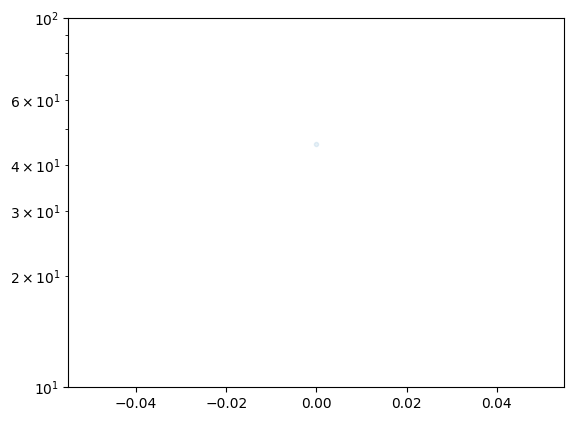

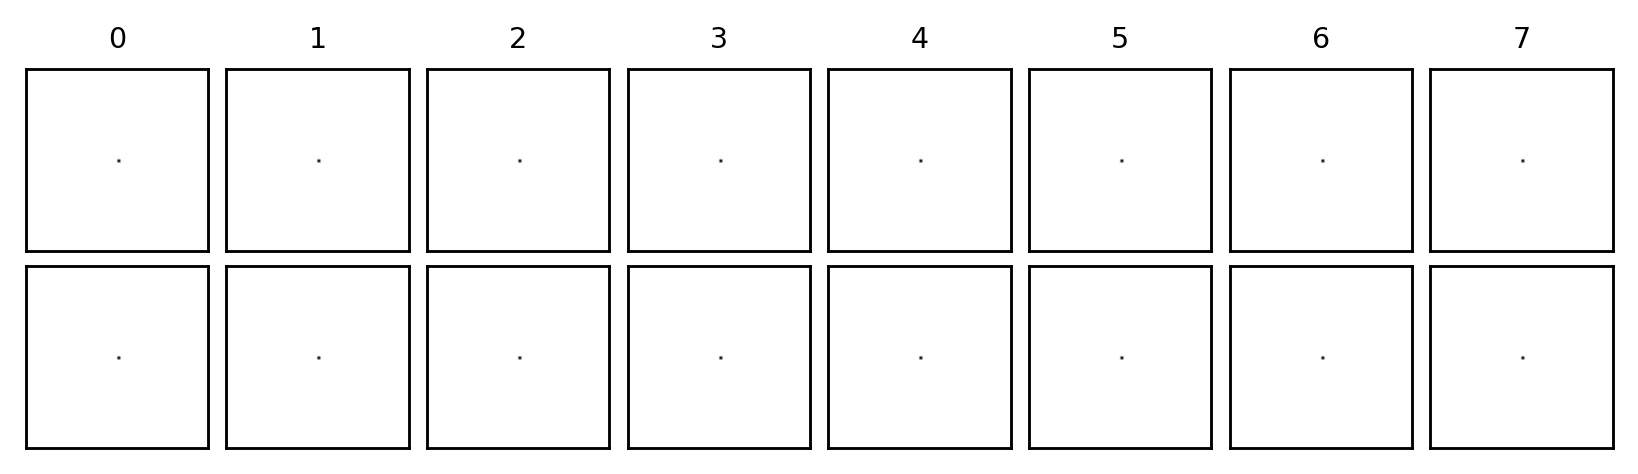

step: 0 	loss: 45.42992401123047 	min-loss: 45.42992401123047 	lr: 1.0495000000000166e-05

  0%|          | 0/5001 [00:01<?, ?it/s]


RuntimeError: shape mismatch: value tensor of shape [3] cannot be broadcast to indexing result of shape [16, 3, 1]

In [11]:
_TRAIN_MODEL_ = True
_EPOCHS_ = 5_000
_NUM_DAMG_ = 4
_DAMG_RATE_ = 2
_INFO_RATE_ = 500
_SAVE_RATE_ = 5000
_VIDEO_RATE_ = 5000

# * save model method
def save_model(_dir, _model, _name):
    model_path = pathlib.Path(_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    torch.save(_model.state_dict(), _dir + '\\' + _name + '.pt')
    
    # * save model parameters
    dict = {
        # seed info
        '_SEED_FILE_': _SEED_FILE_,
        '_SIZE_': _SIZE_,
        '_SEED_ANGLE_RAD_':_SEED_ANGLE_RAD_,
        # target image info
        '_TARGET_FILE_': _TARGET_FILE_,
        '_TARGET_SIZE_': _TARGET_SIZE_,
        '_PAD_': _PAD_,
        # kernel dividers
        '_SOBEL_DIV_': _SOBEL_DIV_,
        '_LAP_DIV_': _LAP_DIV_,
        # model info
        '_CHANNELS_': _CHANNELS_,
        '_HIDDEN_': _HIDDEN_,
        '_MODEL_TYPE_': _MODEL_TYPE_,
        '_IS_STEERABLE_': _IS_STEERABLE_,
        '_ANGLE_CHANNEL_': _ANGLE_CHANNEL_,
        '_STOCHASTIC_UPDATE_RATE_': _STOCHASTIC_UPDATE_RATE_,
        # loss/lr info
        '_LOSS_FUNC_': _LOSS_FUNC_,
        '_LOWER_LR_': _LOWER_LR_,
        '_UPPER_LR_': _UPPER_LR_,
        # training info
        '_DEVICE_': _DEVICE_,
        '_NAME_': _NAME_,
        '_EPOCHS_': _EPOCHS_,
        '_POOL_SIZE_': _POOL_SIZE_,
        '_BATCH_SIZE_': _BATCH_SIZE_,
        '_NUM_DAMG_': _NUM_DAMG_,
        # training rate info
        '_DAMG_RATE_': _DAMG_RATE_,
        '_INFO_RATE_': _INFO_RATE_,
        '_SAVE_RATE_': _SAVE_RATE_,
    }
    json_object = json.dumps(dict, indent=4)
    with open(_dir + '\\' + _name + '_params.json', 'w') as outfile:
        outfile.write(json_object)
    print ('model + params saved!')

loss_log = []
progress = 0

# * begin training 
for _ in tqdm(range(_EPOCHS_+1)):
    if not _TRAIN_MODEL_:
        print ('skipping training')
        break
    with torch.no_grad():
        # * sample batch from pool
        i = len(loss_log)
        batch_idxs = np.random.choice(_POOL_SIZE_, _BATCH_SIZE_, replace=False)
        x = pool[batch_idxs]
        
        # * re-order batch based on loss
        loss_ranks = torch.argsort(loss_func[_LOSS_FUNC_](x, target_batch, _dims=[-2, -3, -1]), descending=True)
        x = x[loss_ranks]
        
        # * re-add seed into batch
        x[:1] = seed

        # * randomize angles for steerable models
        if _IS_STEERABLE_:
            # * randomize angles for steerable models
            if _ANGLE_CHANNEL_ == 'RANDOMIZED':
                for j in range(_POOL_SIZE_):
                    rand = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                    pool[j, -1:] = rand
            # * set direction of growth
            elif _ANGLE_CHANNEL_ == 'DIRECTION':
                for j in range(_POOL_SIZE_):
                    pool[j, -1:] = 0
            
        # * damage lowest loss in batch
        if i % _DAMG_RATE_ == 0:
            # * use random half mask
            if i % 10 == 0:
                mask = half_mask(_SIZE_, 'rand')
            # * use random circle mask
            else:
                radius = random.uniform(_SIZE_*0.05, _SIZE_*0.2)
                u = random.uniform(0, 1) * _SIZE_
                v = random.uniform(0, 1) * _SIZE_
                mask = circle_mask(_SIZE_, radius, [u, v])
            x[-_NUM_DAMG_:] *= torch.tensor(mask).to(_DEVICE_)
            
    # * save batch before
    if i % _INFO_RATE_ == 0:
        before = x.detach().cpu()

    # * different loss values
    overflow_loss = 0.0
    diff_loss = 0.0
    target_loss = 0.0
    
    # * forward pass
    num_steps = np.random.randint(64, 96)
    for _ in range(num_steps):
        prev_x = x
        x = model(x)
        diff_loss += (x - prev_x).abs().mean()
        if _IS_STEERABLE_:
            overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :_CHANNELS_-1].square().sum()
        else:
            overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :_CHANNELS_].square().sum()
    
    # * calculate losses
    target_loss += loss_func[_LOSS_FUNC_](x, target_batch)
    target_loss /= 2.0
    diff_loss *= 10.0
    loss = target_loss + overflow_loss + diff_loss

    
    # * backward pass
    with torch.no_grad():
        loss.backward()
        # * normalize gradients 
        for p in model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        # * re-add batch to pool
        pool[batch_idxs] = x
        loss_log.append(loss.item())
        
        # * print out info
        if i % _INFO_RATE_ == 0:
            # * show loss plot
            clear_output(True)
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.show()
            
            # * show batch
            after = x.detach().cpu()
            show_batch(_BATCH_SIZE_, before, after)
            
            # * print info
            print('\rstep:', i, '\tloss:', loss.item(), '\tmin-loss:', np.min(loss_log),  '\tlr:', lr_sched.get_last_lr()[0], end='')
                
        # * save checkpoint
        if i % _SAVE_RATE_ == 0 and i != 0:
            save_model('_checkpoints', model, _NAME_+'_cp'+str(i))
            
        # * create video
        if i % _VIDEO_RATE_ == 0 and i != 0:
            vidgen(f'_videos/{_NAME_}_cp{i}.mp4', model, p=1, n_frames=256, sz=_SIZE_)
            
# * save final model
if _TRAIN_MODEL_:
    save_model('_models', model, _NAME_)
    vidgen(f'_videos/_final_{_NAME_}.mp4', model, n_frames=256, sz=_SIZE_)

Play Model!

In [ ]:
import pygame
import datetime
import json
import os
import cv2
import imutils

_PLAY_ = True
_MODELS_DIR_ = '_models'
_PLAY_DEVICE_ = 'cuda'
_RADIUS_ = 8
_PLAY_SIZE_ = 64
_WINDOW_SCALE_ = 10
_WINDOW_BG_COLOR_ = (255, 255, 255)
_WINDOW_TEXT_COLOR_ = (0, 0, 0)

# * set current device
_DEVICE_ = _PLAY_DEVICE_

# * method to load model for play
def load_model(_model_name):
    # * read params from json file
    params = {}
    with open(_MODELS_DIR_+'\\'+_model_name+'_params.json', 'r') as openfile:
        params = json.load(openfile)

    # * set important parameters
    global _SOBEL_DIV_
    global _LAP_DIV_ 
    global _MODEL_TYPE_
    global _IS_STEERABLE_
    global _LOSS_FUNC_
    global _ANGLE_CHANNEL_
    global _CHANNELS_
    _SOBEL_DIV_ = params['_SOBEL_DIV_']
    _LAP_DIV_ = params['_LAP_DIV_']
    _MODEL_TYPE_ = params['_MODEL_TYPE_']
    _IS_STEERABLE_ = params['_IS_STEERABLE_']
    _ANGLE_CHANNEL_ = params['_ANGLE_CHANNEL_']
    _LOSS_FUNC_ = params['_MODEL_TYPE_']
    _CHANNELS_ = params['_CHANNELS_']
    
    # * load in model
    model = ISO_NCA(_device=_PLAY_DEVICE_, _model_type=_MODEL_TYPE_)
    model.load_state_dict(torch.load(_MODELS_DIR_+'\\'+_model_name+'.pt', map_location=_PLAY_DEVICE_))
    model.eval()

    # * create seed and tensor
    seed_img = load_image_as_tensor('..\\_seeds\\'+params['_SEED_FILE_'], params['_SIZE_'])
    seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']))
    pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
    seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
    tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
    # * randomize angles for steerable models
    if _IS_STEERABLE_:
        # * randomize angles for steerable models
        if _ANGLE_CHANNEL_ == 'RANDOMIZED':
            tensor[:, -1:] = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
        # * set direction of growth
        elif _ANGLE_CHANNEL_ == 'DIRECTION':
            tensor[:, -1:] = torch.tensor(np.full((_SIZE_), params['_SEED_ANGLE_RAD_']))
    return model, tensor, params, seed_img

# * get list of seeds
seeds_list = os.listdir('..\\_seeds')
seeds_list = [item for item in seeds_list if item.endswith('.png')]
print ('seeds: ', seeds_list)
curr_seed = 0

# * get list of models
model_list = os.listdir(_MODELS_DIR_)
model_list = [item.replace('.pt', '') for item in model_list if item.endswith('.pt')]
print ('models: ', model_list)
curr_model = 0

# load first model
model, tensor, params, seed_img = load_model(model_list[curr_model])

# * misc params
angle = 0.0
fps = 0
show_vecs = False
bg_color = 'WHITE' if _WINDOW_BG_COLOR_ == (255, 255, 255) else 'BLACK'
prev_time = datetime.datetime.now()

# * load vector image
vec_img = cv2.imread('..\\_images\\vector_v3.png')
vec_img = cv2.resize(vec_img, (_WINDOW_SCALE_, _WINDOW_SCALE_))
vec_img = vec_img.astype(float)/255.0

# * start pygame
pygame.init()
pygame.display.set_caption('nca play - '+params['_NAME_'])

# * model dependent params
size = _PLAY_SIZE_
window_size = size * _WINDOW_SCALE_
window = pygame.display.set_mode((window_size, window_size))

# * text renders
font_size = 20
my_font = pygame.font.SysFont('consolas', font_size)
model_surface = my_font.render('[UP/DOWN] model: ' + params['_NAME_'], False, _WINDOW_TEXT_COLOR_)
seed_surface = my_font.render('[LEFT/RIGHT] seed: ' + params['_SEED_FILE_'], False, _WINDOW_TEXT_COLOR_)
text_surface = my_font.render('[SCROLL] angle: ' + str(angle) + 'π', False, _WINDOW_TEXT_COLOR_)
fps_surface = my_font.render('fps: ' + str(int(fps)), False, _WINDOW_TEXT_COLOR_)
vec_surface = my_font.render('[V] show vectors: ' + str(show_vecs), False, _WINDOW_TEXT_COLOR_)

# * start infinite game loop
running = True
mouse_down = False
model_start = False
while running:
    if not _PLAY_:
        print ('skipping game')
        break
    # empty cache
    torch.cuda.empty_cache()
    # handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            # * close application
            if event.key == pygame.K_ESCAPE:
                running = False
                break
            # * toggle showing vectors
            if event.key == pygame.K_v:
                show_vecs = not show_vecs
                vec_surface = my_font.render('[V] show vectors: ' + str(show_vecs), False, _WINDOW_TEXT_COLOR_)
            # * start current model
            if event.key == pygame.K_SPACE:
                model_start = not model_start
            # * reset current model
            if event.key == pygame.K_r:
                model_start = False
                seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
                pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
                seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
                tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
                # * randomize angles for steerable models
                if _IS_STEERABLE_:
                    # * randomize angles for steerable models
                    if _ANGLE_CHANNEL_ == 'RANDOMIZED':
                        tensor[:, -1:] = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                    # * set direction of growth
                    elif _ANGLE_CHANNEL_ == 'DIRECTION':
                        tensor[:, -1:] = torch.tensor(np.full((_SIZE_), params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
            # * use up/down arrow keys to cycle though models
            if event.key == pygame.K_UP:
                    curr_model += 1
                    if curr_model >= len(model_list):
                        curr_model = 0
            if event.key == pygame.K_DOWN:
                curr_model -= 1
                if curr_model < 0:
                    curr_model = len(model_list)-1
            # * load new model
            if event.key == pygame.K_UP or event.key == pygame.K_DOWN:
                model_start = False
                model, tensor, params, seed_img = load_model(model_list[curr_model])
                pygame.display.set_caption('nca play - '+params['_NAME_'])
                model_surface = my_font.render('[UP/DOWN] model: '+params['_NAME_'], False, _WINDOW_TEXT_COLOR_)
                seed_surface = my_font.render('[LEFT/RIGHT] seed: '+params['_SEED_FILE_'], False, _WINDOW_TEXT_COLOR_)
            # * use left/right arrow keys to cycle though seeds
            if event.key == pygame.K_LEFT:
                curr_seed += 1
                if curr_seed >= len(seeds_list):
                    curr_seed = 0
            if event.key == pygame.K_RIGHT:
                curr_seed -= 1
                if curr_seed < 0:
                    curr_seed = len(seeds_list)-1
            # * load new seed image
            if event.key == pygame.K_LEFT or event.key == pygame.K_RIGHT:
                model_start = False
                seed_img = load_image_as_tensor('..\\_seeds\\'+seeds_list[curr_seed], params['_SIZE_'])
                seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']))
                pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
                seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
                tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
                # * randomize angles for steerable models
                if _IS_STEERABLE_:
                    # * randomize angles for steerable models
                    if _ANGLE_CHANNEL_ == 'RANDOMIZED':
                        tensor[:, -1:] = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                    # * set direction of growth
                    elif _ANGLE_CHANNEL_ == 'DIRECTION':
                        tensor[:, -1:] = torch.tensor(np.full((_SIZE_), params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
                seed_surface = my_font.render('[LEFT/RIGHT] seed: '+seeds_list[curr_seed], False, _WINDOW_TEXT_COLOR_)
        if event.type == pygame.MOUSEWHEEL:
            # * let player rotate seed before starting model
            if not model_start:
                angle = np.round((event.y * 0.05)+angle, decimals=2)
                text_surface = my_font.render('[SCROLL] angle: ' + str(angle) + 'π', False, _WINDOW_TEXT_COLOR_)
                seed_img_rot = trans.rotate(seed_img, np.rad2deg(params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
                pad = np.round((_PLAY_SIZE_ - params['_SIZE_'])/2.0, 0).astype(int)
                seed_pad = func.pad(seed_img_rot, (pad, pad, pad, pad), 'constant', 0)
                tensor = torch.cat([seed_pad, seed_pad[:, 3].repeat(1, 12, 1, 1)], 1).to(_DEVICE_)
                # * randomize angles for steerable models
                if _IS_STEERABLE_:
                    # * randomize angles for steerable models
                    if _ANGLE_CHANNEL_ == 'RANDOMIZED':
                        tensor[:, -1:] = torch.rand(_SIZE_, _SIZE_)*np.pi*2.0
                    # * set direction of growth
                    elif _ANGLE_CHANNEL_ == 'DIRECTION':
                        tensor[:, -1:] = torch.tensor(np.full((_SIZE_), params['_SEED_ANGLE_RAD_']+(angle*np.pi)))
        # * mouse click events - erase and draw
        if event.type == pygame.MOUSEBUTTONDOWN:
            mouse_down = True
            if pygame.mouse.get_pressed(3)[2] and model_start:
                mouse = np.array(pygame.mouse.get_pos(), dtype=float)
                pos = mouse / window_size * size
                dot = np.zeros_like(tensor.detach().cpu().numpy())
                dot[:, 3:, int(pos[1]), int(pos[0])] = 1.0
                tensor += torch.tensor(dot).to(_PLAY_DEVICE_)
        if event.type == pygame.MOUSEBUTTONUP:
            mouse_down = False
        if (event.type == pygame.MOUSEMOTION or event.type == pygame.MOUSEBUTTONDOWN) and mouse_down and model_start:
            mouse = np.array(pygame.mouse.get_pos(), dtype=float)
            pos = mouse / window_size * size
            if pygame.mouse.get_pressed(3)[0]:
                mask = circle_mask(size, _RADIUS_, pos)
                tensor[0:] *= torch.tensor(mask).to(_PLAY_DEVICE_)
            
    # * update tensor
    if model_start:
        with torch.no_grad():
            tensor = model(tensor)
    
    # * draw tensor to window
    window.fill(_WINDOW_BG_COLOR_)
    img = to_rgb(tensor, _alpha=bg_color).squeeze()
    vis = (np.array(img.cpu())*255).astype(np.uint8)
    if show_vecs:
        vecs = tensor[:, -1:].squeeze(0)
        vecs = np.array(vecs.cpu())%(2.0*torch.pi)
        pixel = pygame.Surface((_WINDOW_SCALE_, _WINDOW_SCALE_))
    else:
        pixel = pygame.Surface((_WINDOW_SCALE_, _WINDOW_SCALE_))
    for j in range(size):
        for i in range(size):
            color = vis[:, i, j]
            # * create vectors for each cell
            if show_vecs:
                vec_dir = vecs[:, i, j]
                vec = imutils.rotate(vec_img, angle=np.rad2deg(vec_dir).item())
                vec *= color
                surf = pygame.surfarray.make_surface(vec)
                pixel.blit(surf, (0, 0))
            # * fill cell with color
            else:
                pixel.fill(color)
            draw_me = pygame.Rect(j*_WINDOW_SCALE_, i*_WINDOW_SCALE_, _WINDOW_SCALE_, _WINDOW_SCALE_)
            window.blit(pixel, draw_me)
    
    # * calculate fps
    now = datetime.datetime.now()
    if (now - prev_time).seconds >= 1.0:
        prev_time = now
        fps_surface = my_font.render('fps: ' + str(int(fps)), False, _WINDOW_TEXT_COLOR_)
        fps = 0
    else:
        fps += 1       
    
    # * render text
    window.blit(model_surface, (0, 0))
    window.blit(seed_surface, (0, font_size))
    window.blit(text_surface, (0, window_size-font_size))
    window.blit(vec_surface, (0, window_size-font_size*2))
    window.blit(fps_surface, (0, window_size-font_size*3))
    
    # * flip it!
    pygame.display.flip()

# * quit it!
pygame.quit()

In [ ]:
_CREATE_VIDEO_ = False
_VIDEO_MODEL_ = 'angle_steer_cowboy_2_seeds_v5'
global _DEVICE_
global _PLAY_DEVICE_
_DEVICE_ = 'cuda'
_PLAY_DEVICE_ = 'cuda'
    
if _CREATE_VIDEO_:
    model, tensor, params, seed_img = load_model(_VIDEO_MODEL_)
    vidgen(f'_videos/{_VIDEO_MODEL_}.mp4', model, n_frames=256, sz=64)